<a href="https://colab.research.google.com/github/MariiaKalinina/Elasticity/blob/main/Permeability_from_TC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import torch
from math import *
from scipy import integrate
from numpy import linalg as LA
import matplotlib.pyplot as plt
%matplotlib inline
from numba import njit
import numpy as np
from scipy.integrate import dblquad

import matplotlib.pylab as plt
import seaborn as sns
import pandas as pd
from pathlib import Path
import matplotlib.colors

import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
%matplotlib inline
csfont = {'fontname':'Times New Roman'}

In [4]:
# !pip install GitPython
from git import Repo
!git clone https://github.com/MariiaKalinina/Elasticity.git


Cloning into 'Elasticity'...
remote: Enumerating objects: 188, done.
remote: Counting objects: 100% (88/88), done.
remote: Compressing objects: 100% (84/84), done.
remote: Total 188 (delta 64), reused 4 (delta 4), pack-reused 100
Receiving objects: 100% (188/188), 3.84 MiB | 13.48 MiB/s, done.
Resolving deltas: 100% (136/136), done.


In [5]:
path_to_ser = Path('/content/Elasticity/Tver.xlsx')
df_ues = pd.read_excel(path_to_ser, sheet_name='All properties', skiprows=0)

In [6]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [7]:
data = df_ues.copy()
data.drop('#', axis=1, inplace=True)

In [9]:
data[:5]

,Sample,Well,Litholohy,"Porosity,%",Permeability,Density (water),Density (oil),Vp air,Vs air,Vp oil,Vs oil,Vp water,Vs water,Unnamed: 14,AR thermal,AO electrical
0,113480,a,"пористо-кавернозный, скол на торце, закрытые и полуоткрытые трещины",4.524900,0.832741,2.572247,2.576227,5.037000,2.360000,5.564425,3.019440,5.2945,2.6495,NaN,0.066681,0.069183
1,113532,a,пористо-кавернозный,6.473371,0.253703,2.537162,2.529374,4.042333,2.427667,5.173550,2.849075,5.0545,2.6650,NaN,0.134276,0.087096
2,113536,a,пористо-кавернозный,15.024288,18.334600,2.285245,2.297374,3.514333,1.997000,4.103260,2.256210,4.0285,2.2330,NaN,0.131826,0.104713
3,113541,a,пористо-кавернозный,14.192654,17.343900,2.326067,2.319278,3.241000,1.837667,3.971235,2.164210,3.8155,2.0285,NaN,0.122462,0.095499
4,113556,a,пористо-кавернозный,9.432966,15.777000,2.459785,2.445896,3.798667,2.336333,4.759910,2.564645,4.8270,2.5030,NaN,0.081658,0.072444


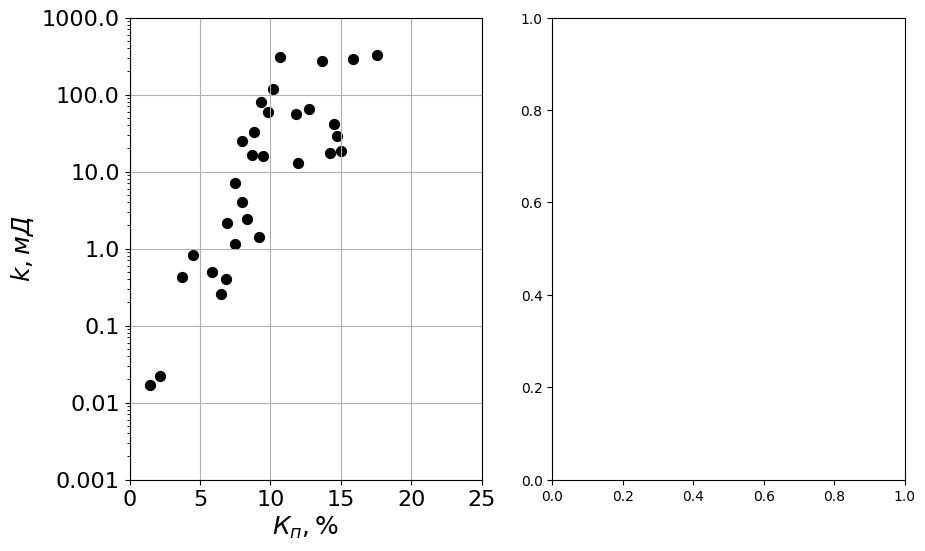

In [30]:
fig = plt.figure(constrained_layout=False, figsize=(10, 6))
# fig.tight_layout(pad=0.001000)
axs = fig.subplots(1, 2,  sharex=False)



ticks_size, label_size = 16, 18

        ### Porosity VS Permeability (all samples)


x_value, y_value = "Porosity,%", "Permeability"

  ### INPUT DATA
axs[0].scatter(df_ues[x_value], df_ues[y_value], color='Black', s=50)
axs[0].set_xscale("linear")
axs[0].set_xlabel("$К_{п}, $"+"$\%$", fontsize=label_size, **csfont, fontweight='bold')
axs[0].set_xlim([0, 25])
axs[0].set_xticks(np.arange(0, 26, 5))
axs[0].set_xticklabels(np.arange(0, 26, 5), fontsize=ticks_size)
axs[0].set_yscale('log', base=10)
axs[0].grid(which='major', axis='both', linestyle='-')

axs[0].set_yscale('log')
axs[0].set_ylabel('${k}, мД$', fontsize=label_size, fontweight='bold')
axs[0].set_ylim([10**-3, 10**3])
axs[0].set_yticks(np.logspace(-3, 3, num=7))
axs[0].set_yticklabels(np.logspace(-3, 3, num=7), fontsize=ticks_size)


plt.show()

Границы ХШ

In [31]:
def Upper_Hashin_Strikman(phi, lam):
    L0 = max(lam)
    f = 1 / 3  # Границы ХШ - частный случай ОСП, тело сравние - мин.матрица=верхняя граница; флюид=нижняя граница.
                # Все включения только сферические АО=1, F деполяризации 1/3
    HS_comp1, HS_comp2 = [], []

    for i, j in zip(phi, lam):
        termc_3 = i * j / (L0 * (1-f)+j * f)
        termz_3 = i / (L0 * (1-f)+j * f)

        termc_12 = i * j / (L0 * (1+f) / 2+j * (1-f) / 2)
        termz_12 = i / (L0 * (1+f) / 2+j * (1-f) / 2)

        termc_all = (termc_3+2 * termc_12) / 3
        termz_all = (termz_3+2 * termz_12) / 3

        t16 = termc_all
        t15 = termz_all

        HS_comp1.append(t16)  # параллельная компонента ТС
        HS_comp2.append(t15)  # перпендикулярная компонента ТС
    i = 0
    for k in HS_comp1:
        i += k
    j = 0
    for k in HS_comp2:
        j += k

    L_eff = i / j
    # print('TC Upper Hashin-Strikman:', L_eff)
    return L_eff


def Lower_Hashin_Strikman(phi, lam):
    L0 = min(lam)
    f = 1 / 3  # Границы ХШ - частный случай ОСП, тело сравние - мин.матрица=верхняя граница; флюид=нижняя граница.
                # Все включения только сферические АО=1, F деполяризации 1/3
    HS_comp1, HS_comp2 = [], []

    for i, j in zip(phi, lam):
        termc_3 = i * j / (L0 * (1-f)+j * f)
        termz_3 = i / (L0 * (1-f)+j * f)

        termc_12 = i * j / (L0 * (1+f) / 2+j * (1-f) / 2)
        termz_12 = i / (L0 * (1+f) / 2+j * (1-f) / 2)

        termc_all = (termc_3+2 * termc_12) / 3
        termz_all = (termz_3+2 * termz_12) / 3

        t16 = termc_all
        t15 = termz_all

        HS_comp1.append(t16)  # параллельная компонента ТС
        HS_comp2.append(t15)  # перпендикулярная компонента ТС
    i = 0
    for k in HS_comp1:
        i += k
    j = 0
    for k in HS_comp2:
        j += k

    L_eff = i / j
    return L_eff

def Average_Hashin_Strikman(phi, lam):
    return np.mean([Lower_Hashin_Strikman(phi, lam), Upper_Hashin_Strikman(phi, lam)])

ОСП - теплопроводность, проницаемость

In [32]:
def effective_tc(conc, alpha_shape, lam):

    x0=0

    phi = conc

    #------------------depolarization factor calculation-----
    def depolarizaton(alpha):
        if alpha < 1:
            t1 = alpha ** 2
            t2 = 1 / t1
            t4 = np.sqrt(t2-1)
            t5 = np.arctan(t4)
            t8 = t4 ** 2
            form = t2 * (t4-t5) / t8 / t4
            return form
        elif alpha > 1:
            t1 = alpha ** 2
            t2 = 1 / t1
            t4 = np.sqrt(1-t2)
            t6 = np.log(1+t4)
            t9 = np.log(1-t4)
            t13 = t4 ** 2
            form = t2 * (t6 / 2-t9 / 2-t4) / t13 / t4
            return form
        elif alpha == 1:
            form = 1 / 3
            return form


    depolar_F = []
    for i in alpha_shape:
        depolar_F.append(depolarizaton(i))

    L0 = lam[0]

    def raschet(L0):

        parall_comp, perpen_comp = [], []
#         print('Тело сравнения', L0)

        for i, j, f in zip(phi, lam, depolar_F):

#             print('Каждая комопонента')
#             print(i, j, f)

            termc_3 = i * j / (L0 * (1-f)+j * f)
            termz_3 = i / (L0 * (1-f)+j * f)

            termc_12 = i * j / (L0 * (1+f) / 2+j * (1-f) / 2)
            termz_12 = i / (L0 * (1+f) / 2+j * (1-f) / 2)

            termc_all = (termc_3+2 * termc_12) / 3
            termz_all = (termz_3+2 * termz_12) / 3

            t16 = termc_all # числитель
            t15 = termz_all # Знаменатель

#             print('ТС матрицы', j)
#             print('t16:' , t16)
#             print('t15:' , t15)

            parall_comp.append(t16)  # числитель формулы (матрица, флюид)
            perpen_comp.append(t15)  # знаменатель формулы (матрица, флюид)

#         print('Параллельный компоненты ТС', parall_comp)
#         print('Перпендикулярные компоненты ТС', perpen_comp)

        L_eff = np.sum(parall_comp) / np.sum(perpen_comp)
#         print('TC eff: ', L_eff, end='\n\n')
        return L_eff

    x0 = L0
    L0 = raschet(x0)
    it_f = 1
    while abs(x0-L0) >= 10 **-6:
        x0 = L0
        L0 = raschet(x0)
        it_f += 1

#     print('Количество итераций: ', it_f, end='\n\n')
    return L0
#     print('Эффективное значение TC_eff:', raschet(L0))


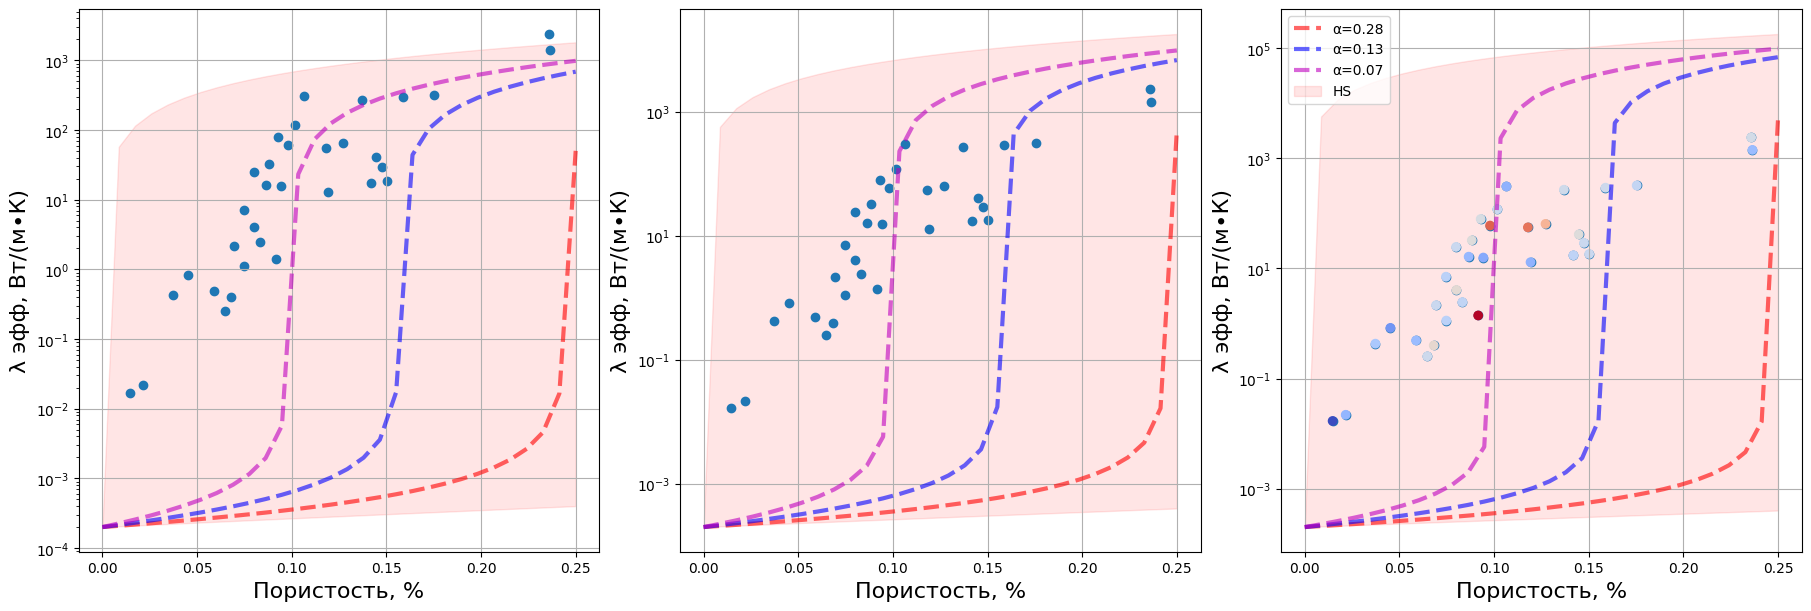

In [68]:
fig5 = plt.figure(layout='constrained', figsize=(18, 6))
axs = fig5.subplots(1, 3, sharex=True)

porosity = np.linspace(0, 0.25, 30)

mtrx_perm=2*10**-4

# matrix_lam = [(3.03, fluid_lam), (3.45, fluid_lam), (3.97, fluid_lam)] # из уравнения регрессии
matrix_lam = [(mtrx_perm, 10**4),
 (mtrx_perm, 10**5),
  (mtrx_perm, 10**6)] # подобранные из границ ХШ

for ax, mlam in zip(axs, matrix_lam):

    tc_eff_air2, tc_eff_water2, tc_eff_oil2 = [], [], []
    por = porosity

    alpha_shape = [1, 0.28]
    for i in por:
        conc = [1-i, i]
        tc_eff_air2.append(effective_tc(conc, alpha_shape, mlam))

    alpha_shape = [1, 0.13]
    for i in por:
        conc = [1-i, i]
        tc_eff_water2.append(effective_tc(conc, alpha_shape, mlam))


    alpha_shape = [1, 0.07]
    for i in por:
        conc = [1-i, i]
        tc_eff_oil2.append(effective_tc(conc, alpha_shape, mlam))

    tc_hs_up, tc_hs_dw, tc_hs_mean = [], [], []

    for i in porosity:
        conc = [1-i, i]

        tc_hs_up.append(Upper_Hashin_Strikman(conc, mlam))
        tc_hs_dw.append(Lower_Hashin_Strikman(conc, mlam))

    ax.plot(por, tc_eff_air2, 'r--', lw=3, alpha=0.6, label='α=0.28')
    ax.plot(por, tc_eff_water2, 'b--', lw=3, alpha=0.6, label='α=0.13')
    ax.plot(por, tc_eff_oil2, 'm--', lw=3, alpha=0.6, label='α=0.07')



    ax.fill_between(porosity, tc_hs_up, tc_hs_dw, color='r', alpha=.1, label='HS')

    ax.set_ylabel('λ эфф, Вт/(м∙К)', fontsize=16)
    ax.set_xlabel('Пористость, %', fontsize=16)
    ax.grid(which='major', axis='both', linestyle='--')
    # ax.set_xlim([0, 0.25])
    # ax.set_xticks(np.arange(0, 0.25, 0.05), fontsize=20)


# x_value, y_value = "Porosity,%", "Permeability"

# plot1
axs[0].scatter(data["Porosity,%"]/100, data["Permeability"])
axs[0].set_yscale('log', base=10)
axs[0].grid(which='major', axis='both', linestyle='-')

# plot2
axs[1].scatter(data["Porosity,%"]/100, data["Permeability"])
axs[1].set_yscale('log', base=10)
axs[1].grid(which='major', axis='both', linestyle='-')

# plot2
axs[2].scatter(data["Porosity,%"]/100, data["Permeability"])
axs[2].set_yscale('log', base=10)
axs[2].grid(which='major', axis='both', linestyle='-')

colors = data['AR thermal']  # Assuming 'permeability' contains values to map colors
axs[2].scatter(data["Porosity,%"]/100, data["Permeability"], c=colors, cmap='coolwarm', marker='o')

axs[2].legend(loc='best', fontsize='medium')


plt.show()